# FIT3179 Data Visualisation 2

Source: https://www.kaggle.com/datasets/alphajuliet/au-dom-traffic?resource=download
Origionally Sourced From: https://data.gov.au/dataset/ds-dga-c5029f2a-39b3-4aef-8ae1-73e7962f6170/details as Domestic Airlines - Top Routes (CSV)

Working with a single data set file containing aggregate details on Australian Domestic Flights each month from Jan-1984 to Aug-2021.

### Verbatim Notes Provided by Original Source

The data cover revenue passengers carried by Australian-registered operators of scheduled regular public transport services over Australian flight stages. 
These estimates include passengers carried between domestic airports on international flights operated by these carriers.
The passengers carried refer to traffic on board by stages.
Traffic on board by stages - The total of all traffic (revenue passengers) on each flight stage between two directly connected airports.

Individual routes shown are restricted to those with an average exceeding 8 000 passengers per month over the previous six months where two or more airlines operate in competition. For the month of March 2016 there were 66 such routes. 
Cells with zero indicate where data is not available or where the route did not meet the publication criteria above.

**Definitions:**
* Aircraft Trips - The number of flight stages. A return flight counts as two aircraft trips.
* Available Seat Kilometres (ASKs) - Calculated by multiplying the number of seats available on each flight stage, by the distance in kilometres between the ports. The distances used are Great Circle Distances.
* City-Pair - The ports shown make up the city-pair route. Passenger movements shown for a city pair reflect total traffic in both directions.
* Distance - Great Circle Distances between two airports.
* Flight Stage - The operation of an aircraft from take-off to landing.
* Passengers Carried - Revenue passengers carried.
* Passenger Load Factor - The total revenue passenger kilometres performed as a percentage of the total available seat kilometres.
* Regular Public Transport Services (RPT) - All air service operations in which aircraft are available for the transport of members of the public and are conducted in accordance with fixed schedules. It does not include charter or other non-scheduled operations.
* Revenue Passengers - All passengers paying any fare. Frequent flyer redemption travellers are regarded as revenue passengers.
* Revenue Passenger Kilometres (RPKs) - Calculated by multiplying the number of revenue passengers travelling on each flight stage, by the distance in kilometres between the ports. The distances used are Great Circle Distances.

### Column Definitions
* City1: The first part of the origin, destination pair. Note the city1 and city2 values show data for flights in both directions.
* City2: The second part of the origin, destination pair.
* Month: The month-year of the flight data shown.
* Passenger Count: The number of passengers flown between the two cities in the given month.
* Flight Count: The number of flights between the two cities in the given month (in either direction).
* Average Capacity (%): How full the plane is in terms of passenger seating capacity. Average value for the month.
* Flight Distance (km): Distance between airports (using Great Circle distance). Is not the actual distance flow.
* Actual Passenger Distance (km): Flight Distance * Passenger Count
* Potential Passenger Distance (km): Flight Distance * Total Seat Available
* Seats: The total number of seats available on flights for the given month between the two locations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv, os, random, math

In [2]:
# 1000 Seperator
def format_large_numbers(x):
    return '{:,}'.format(x)

# Set the custom formatting function
pd.options.display.float_format = format_large_numbers

In [3]:
path = 'Data/raw_data.csv'
data = pd.read_csv(path)
# Rename the columns
new_names = {
    'Passenger_Trips': 'Passenger Count',
    'Aircraft_Trips': 'Flight Count',
    'Passenger_Load_Factor': 'Average Capacity (%)',
    'Distance_GC_(km)': 'Flight Distance (km)'
}
data.rename(columns=new_names, inplace=True)
# Add field for plane size (in terms of seat count)
data['Plane Size (seats)'] = data['Seats'] / data['Flight Count']
# Remove fields not needed
data.drop(columns=['Month_num', 'RPKs', 'ASKs', 'Seats'], inplace=True)


# Removing Temporal Nature
# Aggregate the data to yearly
data = data.groupby(['Year', 'City1', 'City2'], as_index=False).agg({
    'Passenger Count': 'sum', 'Flight Count': 'sum', 'Average Capacity (%)': 'mean', 
    'Flight Distance (km)': 'mean', 'Plane Size (seats)': 'mean'
})
# Include only 2017 non-zero data (it has the most connections)
data = data[(data['Year']==2017) & (data['Passenger Count'] > 0)]
# Remove the now redundant Year column
data.drop(columns=['Year'], inplace=True)
# Round all numbers to 2dp
data = data.applymap(lambda x: round(x, 2) if isinstance(x, float) else x)


In [4]:
# Get Number of connections for each location
cities = data['City1'].append(data['City2']).unique()
num_connections = {city: 0 for city in cities}
for _, row in data.iterrows():
    num_connections[row['City1']] += 1
    num_connections[row['City2']] += 1

# Rearrange City1 and City2 to have City1 be the the more connected city (where possible)
def rearrange_route(row):
    if num_connections[row['City1']] < num_connections[row['City2']]:
        row['City1'], row['City2'] = row['City2'], row['City1']
    return row
data = data.apply(rearrange_route, axis=1)
data = data.sort_values(by='City1', key=lambda x: data['City1'].map(num_connections), ascending=False)
data = data.reset_index(drop=True)


In [5]:
data

,City1,City2,Passenger Count,Flight Count,Average Capacity (%),Flight Distance (km),Plane Size (seats)
0,SYDNEY,WAGGA WAGGA,182763,5502,63.62,367.0,52.4
1,SYDNEY,BRISBANE,4746256,35401,82.51,753.0,162.4
2,SYDNEY,PERTH,1716477,9031,81.88,"3,284.0",231.98
3,SYDNEY,MELBOURNE,9097339,60075,84.42,706.0,179.33
4,SYDNEY,LAUNCESTON,286425,1940,85.51,914.0,171.9
...,...,...,...,...,...,...,...
63,ADELAIDE,PORT LINCOLN,171499,7418,59.66,246.0,38.85
64,ADELAIDE,GOLD COAST,214185,1481,81.8,"1,607.0",176.68
65,ADELAIDE,CANBERRA,181576,1715,64.03,972.0,165.15
66,DARWIN,ALICE SPRINGS,118772,1766,55.75,"1,305.0",119.84


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   City1                 68 non-null     object 
 1   City2                 68 non-null     object 
 2   Passenger Count       68 non-null     int64  
 3   Flight Count          68 non-null     int64  
 4   Average Capacity (%)  68 non-null     float64
 5   Flight Distance (km)  68 non-null     float64
 6   Plane Size (seats)    68 non-null     float64
dtypes: float64(3), int64(2), object(2)
memory usage: 3.8+ KB


In [7]:
data.describe().round()

,Passenger Count,Flight Count,Average Capacity (%),Flight Distance (km),Plane Size (seats)
count,68.0,68.0,68.0,68.0,68.0
mean,"803,369.0","6,932.0",73.0,"1,176.0",137.0
std,"1,336,011.0","8,870.0",12.0,831.0,48.0
min,"27,958.0",221.0,18.0,236.0,39.0
25%,"188,792.0","2,261.0",66.0,511.0,101.0
50%,"317,518.0","4,540.0",75.0,935.0,157.0
75%,"868,020.0","7,345.0",82.0,"1,582.0",173.0
max,"9,097,339.0","60,075.0",86.0,"3,615.0",232.0


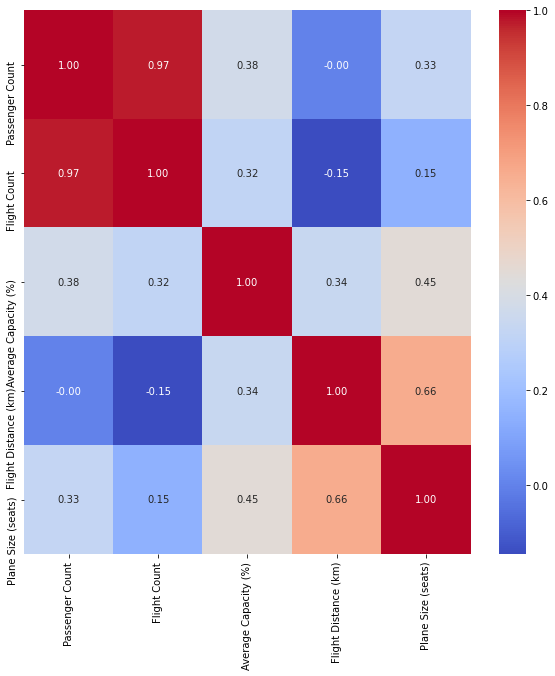

In [8]:
def heatmap(df):
    corr = df.corr()
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.show()
heatmap(data)

## Secondary Dataset
There is a secondary dataset which contains location data for each of the cities. Latitude, Longitude, Population, Area.

This dataset was sourced from Chat-GPT (Sep/25 Version).
Prompts:
* 'I am going to give a list of places in australia. I want a CSV response with the following data about each. Latitude, Longitude, Population, Area (km sq), State. The cities: ADELAIDE,ALBURY,ALICE SPRINGS,BRISBANE,BROOME,CANBERRA,COFFS HARBOUR,DARWIN,DEVONPORT,DUBBO,GOLD COAST,HOBART,KALGOORLIE,KARRATHA,LAUNCESTON,MELBOURNE,PERTH,SUNSHINE COAST,SYDNEY,CAIRNS,BALLINA,HERVEY BAY,PORT MACQUARIE,NEWCASTLE,HAMILTON ISLAND,AYERS ROCK,GERALDTON,BUNDABERG,ARMIDALE,PROSERPINE,MACKAY,ROCKHAMPTON,TOWNSVILLE,BURNIE,MILDURA,WAGGA WAGGA,PORT LINCOLN,PORT HEDLAND,NEWMAN,GLADSTONE,EMERALD,MOUNT ISA,MORANBAH,TAMWORTH'
* Give me the same data but: 1. Abbreviate the State Names, 2. Add a boolean (True, False) field 'Is State Capitol', 3. Add a field 'Airport distance to CBD (km).

### Defining 
Cities are labeled as Capitol, Metro, Regional. Regional Locations are defined as having a population less than 50,000.

In [15]:
#cols = ['Lat', 'Long', 'Pop', 'Area (km sq)', 'State', 'Is Capitol', 'Airport Distance to CBD']
data_locations = pd.read_csv('Data/location_data.csv')
data_locations['Connections'] = data_locations['City'].map(num_connections)
data_locations.drop(columns=['Area (km sq)', 'Airport distance to CBD (km)'], inplace=True)
data_locations = data_locations.sort_values(by=['Connections', 'Population'], ascending=False).reset_index(drop=True)

In [16]:
data_locations

,City,Latitude,Longitude,Population,State,Class,Connections
0,SYDNEY,-33.8688,151.2093,5312163,NSW,Capitol,23
1,BRISBANE,-27.4698,153.0251,2482114,QLD,Capitol,19
2,MELBOURNE,-37.8136,144.9631,5078193,VIC,Capitol,15
3,PERTH,-31.9505,115.8605,2083400,WA,Capitol,11
4,ADELAIDE,-34.9285,138.6007,1345777,SA,Capitol,8
5,DARWIN,-12.4634,130.8456,147255,NT,Capitol,5
6,CANBERRA,-35.2809,149.13,431114,ACT,Capitol,4
7,TOWNSVILLE,-19.2563,146.8237,190631,QLD,Metro,4
8,CAIRNS,-16.9203,145.7709,150920,QLD,Metro,4
9,GOLD COAST,-28.0167,153.4,591473,QLD,Metro,3


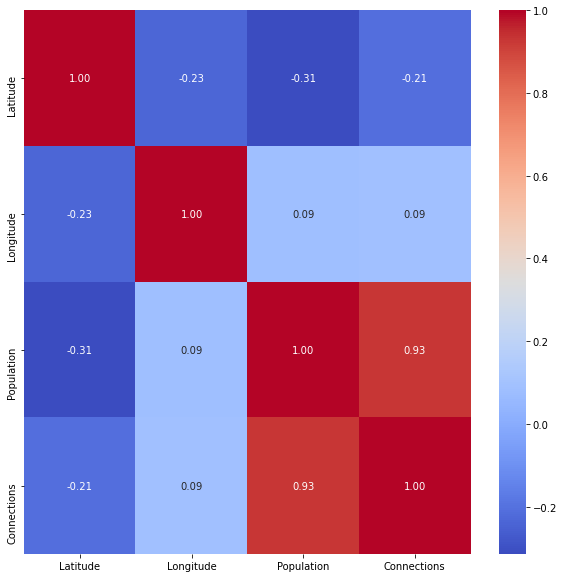

In [11]:
heatmap(data_locations)

### Adding Route Type

We now use `data_locations` to determine the route type for each row in `data`.

In [12]:
city_classes = data_locations.set_index('City')['Class'].to_dict()
def get_routetype(row):
    city1_class = city_classes[row['City1']]
    city2_class = city_classes[row['City2']]
    return f'{city1_class}-{city2_class}'
data['Route Type'] = data.apply(get_routetype, axis=1)

In [13]:
data['Route Type'].value_counts()

Capitol-Regional    25
Capitol-Capitol     21
Capitol-Metro       21
Metro-Metro          1
Name: Route Type, dtype: int64

In [17]:
data

,City1,City2,Passenger Count,Flight Count,Average Capacity (%),Flight Distance (km),Plane Size (seats),Route Type
0,SYDNEY,WAGGA WAGGA,182763,5502,63.62,367.0,52.4,Capitol-Metro
1,SYDNEY,BRISBANE,4746256,35401,82.51,753.0,162.4,Capitol-Capitol
2,SYDNEY,PERTH,1716477,9031,81.88,"3,284.0",231.98,Capitol-Capitol
3,SYDNEY,MELBOURNE,9097339,60075,84.42,706.0,179.33,Capitol-Capitol
4,SYDNEY,LAUNCESTON,286425,1940,85.51,914.0,171.9,Capitol-Metro
...,...,...,...,...,...,...,...,...
63,ADELAIDE,PORT LINCOLN,171499,7418,59.66,246.0,38.85,Capitol-Regional
64,ADELAIDE,GOLD COAST,214185,1481,81.8,"1,607.0",176.68,Capitol-Metro
65,ADELAIDE,CANBERRA,181576,1715,64.03,972.0,165.15,Capitol-Capitol
66,DARWIN,ALICE SPRINGS,118772,1766,55.75,"1,305.0",119.84,Capitol-Regional


## Export

In [14]:
data.to_csv('Data/flight_data_cleaned.csv')
data_locations.to_csv('Data/location_data_cleaned.csv')